In [1]:
import os
import time
import copy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models, datasets
from torchinfo import summary

from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, 
    accuracy_score, precision_recall_fscore_support
)
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [28]:
# ==================== 1. DATA LOADING AND PREPROCESSING ====================
class CustomImageDataset(Dataset):
    """Custom dataset class for image classification"""
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []
        
        # Load all image paths and labels
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_dir, img_name))
                        self.labels.append(self.class_to_idx[class_name])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


def create_dataloaders(data_dir, batch_size=32, img_size=224):
    """Create train, validation, and test dataloaders"""
    # Data transformations
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = CustomImageDataset(
        os.path.join(data_dir, 'seg_train/seg_train'),
        transform=train_transform
    )
    classes = train_dataset.classes
    
    # Split all training data to train/val
    # train_dataset, val_dataset = random_split(train_dataset, [0.8, 0.2])
    # val_dataset.transform = val_test_transform
    val_dataset = CustomImageDataset(
        os.path.join(data_dir, 'seg_test/seg_test'),
        transform=val_test_transform
    )
    
    test_dataset = CustomImageDataset(
        "/kaggle/working/intel_test/",
        transform=val_test_transform
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        pin_memory=True,
        # collate_fn=collate_fn
    )
    
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of validation samples: {len(val_dataset)}")
    print(f"Number of test samples: {len(test_dataset)}")
    print(f"Number of classes: {len(classes)}")
    
    return train_loader, val_loader, test_loader, classes

In [6]:
# ==================== 2. MODEL CONFIGURATION ====================
def create_resnet50_model(num_classes, freeze_layers=True, use_pretrained=True):
    """Create ResNet50 model with optional layer freezing"""
    # Load pretrained ResNet50
    if use_pretrained:
        model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    else:
        model = models.resnet50(weights=None)

    if freeze_layers:
        # Freeze all layers except the final layer
        for param in model.parameters():
            param.requires_grad = False
    
    # Replace the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)
    )
    
    # Unfreeze the last few layers for fine-tuning
    if freeze_layers:
        # Unfreeze the last convolutional block
        for param in model.layer4.parameters():
            param.requires_grad = True
        # Unfreeze the final layer
        for param in model.fc.parameters():
            param.requires_grad = True    

    model = nn.DataParallel(model)
    
    return model.to(device)

In [7]:
# ==================== 3. TRAINING AND VALIDATION FUNCTIONS ====================
def train_epoch(model, dataloader, criterion, optimizer, scheduler=None):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': running_loss / total_samples,
            'acc': (running_corrects.float() / total_samples).item()
        })
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.float() / total_samples
    
    if scheduler:
        scheduler.step()
    
    return epoch_loss, epoch_acc.item()

def validate_epoch(model, dataloader, criterion):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            progress_bar.set_postfix({
                'loss': running_loss / total_samples,
                'acc': (running_corrects.float() / total_samples).item()
            })
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.float() / total_samples
    
    return epoch_loss, epoch_acc.item(), all_preds, all_labels

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, num_epochs=25, patience=5):
    """Main training loop with early stopping"""
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # Early stopping variables
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*50}")
        
        # Training phase
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, scheduler
        )
        
        # Validation phase
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion)
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_model.pth')
            print(f"Saved best model with validation accuracy: {val_acc:.4f}")
        else:
            epochs_no_improve += 1
        
        # Early stopping
        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
    
    print(f"\nTraining completed. Best validation accuracy: {best_acc:.4f} at epoch {best_epoch+1}")
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }

# ==================== 4. TEST EVALUATION ====================
def evaluate_model(model, test_loader, class_names):
    """Evaluate model on test set and return metrics"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )
    
    print(f"\n{'='*50}")
    print("TEST SET RESULTS")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

In [52]:
# ==================== 5. VISUALIZATION FUNCTIONS ====================
def plot_training_history(history):
    """Plot training and validation metrics"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    axes[0].plot(history['train_losses'], label='Train Loss')
    axes[0].plot(history['val_losses'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot accuracy
    axes[1].plot(history['train_accs'], label='Train Accuracy')
    axes[1].plot(history['val_accs'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(cm, class_names, save_path='confusion_matrix.png'):
    """Plot confusion matrix"""
    plt.figure(figsize=(20, 18))
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def visualize_predictions(probs, test_loader, class_names, num_images=9, save_path='predictions.png'):
    """Visualize model predictions on test images"""
    model.eval()

    preds = np.argmax(probs, axis=1)
    images = []
    labels = []
    with torch.no_grad():
        for _inputs, _labels in tqdm(test_loader, desc='Testing'):
            cur_images, cur_labels = _inputs.cpu().numpy(), _labels.cpu().numpy()
            images.extend(cur_images)
            labels.extend(cur_labels)

    images = np.array(images)
    
    # Denormalize images
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    images = images * std + mean
    images = np.clip(images, 0, 1)
    
    # Plot images with predictions
    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()

    rng = np.random.default_rng()
    rand_idx = rng.choice(len(images), size=min(num_images, len(images)), replace=False)
    
    for i, idx in enumerate(rand_idx):
        ax = axes[i]
        ax.imshow(np.moveaxis(images[idx], 0, -1))
        
        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        confidence = probs[idx][preds[idx]]
        
        color = 'green' if true_label == pred_label else 'red'
        
        ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", 
                    color=color, fontsize=10)
        ax.axis('off')
    
    plt.suptitle('Model Predictions on Test Images', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

# Training

In [10]:
# Configuration
config = {
    'data_dir': '/kaggle/input/intel-image-classification',
    'batch_size': 256,
    'num_epochs': 25,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'freeze_layers': True,
    'patience': 5,
    'img_size': 224
}

In [20]:
# 1. Create dataloaders
print("1. Loading dataset...")
train_loader, val_loader, test_loader, class_names = create_dataloaders(
    config['data_dir'],
    batch_size=config['batch_size'],
    img_size=config['img_size']
)

1. Loading dataset...
Number of training samples: 14034
Number of validation samples: 3000
Number of test samples: 3000
Number of classes: 6


In [12]:
# 2. Create model
print("\n2. Creating model...")
model = create_resnet50_model(
    num_classes=len(class_names),
    freeze_layers=config['freeze_layers'],
    use_pretrained=True
)

summary(model, input_size=(config['batch_size'], 3, config['img_size'], config['img_size']))


2. Creating model...
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
DataParallel                                  [256, 6]                  --
├─ResNet: 1-1                                 [128, 6]                  24,560,198
├─ResNet: 1-4                                 --                        (recursive)
│    └─Conv2d: 2-1                            [128, 64, 112, 112]       (9,408)
├─ResNet: 1-3                                 [128, 6]                  --
├─ResNet: 1-4                                 --                        (recursive)
│    └─Conv2d: 2-2                            [128, 64, 112, 112]       --
│    └─BatchNorm2d: 2-3                       [128, 64, 112, 112]       (128)
│    └─BatchNorm2d: 2-4                       [128, 64, 112, 112]       --
│    └─ReLU: 2-5                              [128, 64, 112, 112]       --
│    └─ReLU: 2-6                              [128, 64, 112, 112]       --
│    └─MaxPool2d: 2-7                         [128, 64, 56, 5

In [13]:
# 3. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config['learning_rate'],
    weight_decay=config['weight_decay']
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config['num_epochs'],
    eta_min=1e-6
)

In [14]:
# 4. Train model
print("\n3. Starting training...")
start_time = time.time()

model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=config['num_epochs'],
    patience=config['patience']
)

training_time = time.time() - start_time
print(f"\nTotal training time: {training_time:.2f} seconds")


3. Starting training...

Epoch 1/25


Validation: 100%|██████████| 12/12 [00:24<00:00,  2.04s/it, loss=0.389, acc=0.849]


Train Loss: 0.5044, Train Acc: 0.8211
Val Loss: 0.3889, Val Acc: 0.8490
Saved best model with validation accuracy: 0.8490

Epoch 2/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s, loss=0.321, acc=0.877]


Train Loss: 0.3324, Train Acc: 0.8799
Val Loss: 0.3210, Val Acc: 0.8767
Saved best model with validation accuracy: 0.8767

Epoch 3/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s, loss=0.311, acc=0.884]


Train Loss: 0.3063, Train Acc: 0.8888
Val Loss: 0.3114, Val Acc: 0.8840
Saved best model with validation accuracy: 0.8840

Epoch 4/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s, loss=0.322, acc=0.887]


Train Loss: 0.2891, Train Acc: 0.8933
Val Loss: 0.3223, Val Acc: 0.8867
Saved best model with validation accuracy: 0.8867

Epoch 5/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s, loss=0.294, acc=0.894]


Train Loss: 0.2654, Train Acc: 0.9045
Val Loss: 0.2941, Val Acc: 0.8943
Saved best model with validation accuracy: 0.8943

Epoch 6/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s, loss=0.279, acc=0.896]


Train Loss: 0.2537, Train Acc: 0.9064
Val Loss: 0.2794, Val Acc: 0.8960
Saved best model with validation accuracy: 0.8960

Epoch 7/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.06it/s, loss=0.287, acc=0.895]


Train Loss: 0.2498, Train Acc: 0.9060
Val Loss: 0.2869, Val Acc: 0.8947

Epoch 8/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.07it/s, loss=0.287, acc=0.898]


Train Loss: 0.2313, Train Acc: 0.9157
Val Loss: 0.2865, Val Acc: 0.8977
Saved best model with validation accuracy: 0.8977

Epoch 9/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s, loss=0.279, acc=0.89] 


Train Loss: 0.2262, Train Acc: 0.9144
Val Loss: 0.2788, Val Acc: 0.8900

Epoch 10/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s, loss=0.269, acc=0.9]  


Train Loss: 0.2190, Train Acc: 0.9183
Val Loss: 0.2688, Val Acc: 0.9000
Saved best model with validation accuracy: 0.9000

Epoch 11/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.09it/s, loss=0.306, acc=0.892]


Train Loss: 0.2083, Train Acc: 0.9230
Val Loss: 0.3061, Val Acc: 0.8920

Epoch 12/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.08it/s, loss=0.261, acc=0.904]


Train Loss: 0.2040, Train Acc: 0.9251
Val Loss: 0.2609, Val Acc: 0.9037
Saved best model with validation accuracy: 0.9037

Epoch 13/25


Validation: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s, loss=0.283, acc=0.895]


Train Loss: 0.1904, Train Acc: 0.9298
Val Loss: 0.2828, Val Acc: 0.8947

Epoch 14/25


Validation: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s, loss=0.297, acc=0.897]


Train Loss: 0.1792, Train Acc: 0.9307
Val Loss: 0.2972, Val Acc: 0.8973

Epoch 15/25


Training:  22%|██▏       | 12/55 [00:13<00:47,  1.10s/it, loss=0.176, acc=0.937]


KeyboardInterrupt: 

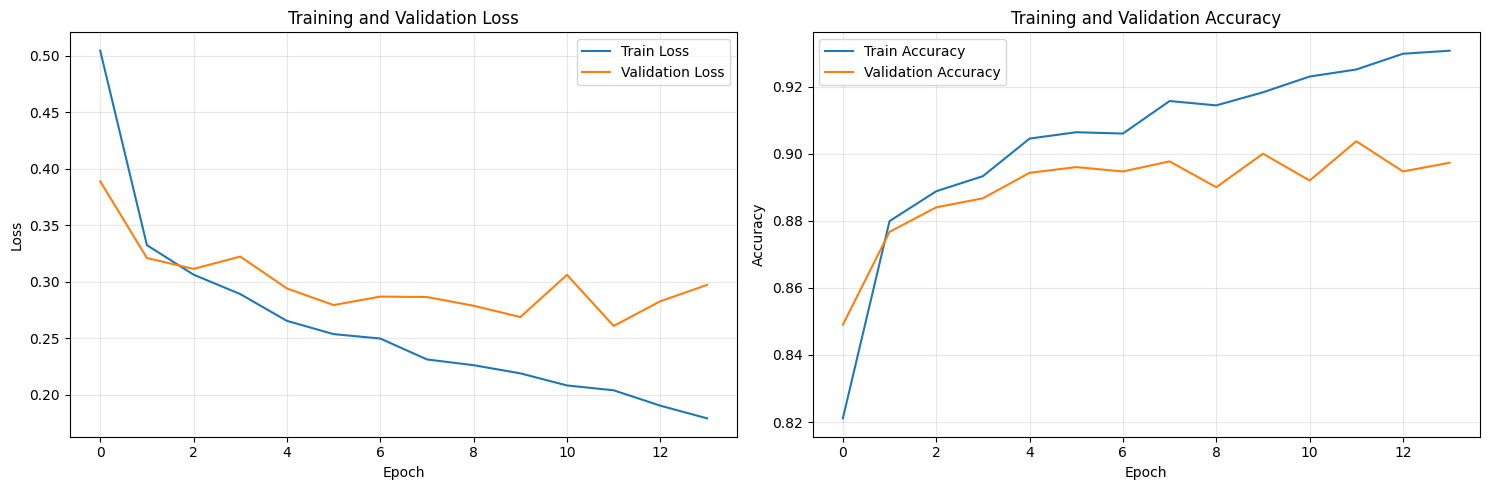

In [68]:
# 5. Plot training history
history = {
    'train_losses': train_losses,
    'train_accs': train_accs,
    'val_losses': val_losses,
    'val_accs': val_accs
}
plot_training_history(history)

# Eval on validation

Testing: 100%|██████████| 12/12 [00:07<00:00,  1.51it/s]



TEST SET RESULTS
Accuracy: 0.9370
Precision: 0.9367
Recall: 0.9370
F1-Score: 0.9368

Classification Report:
              precision    recall  f1-score   support

   buildings       0.94      0.95      0.94       437
      forest       0.99      1.00      0.99       474
     glacier       0.89      0.89      0.89       553
    mountain       0.90      0.88      0.89       525
         sea       0.96      0.98      0.97       510
      street       0.95      0.94      0.95       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



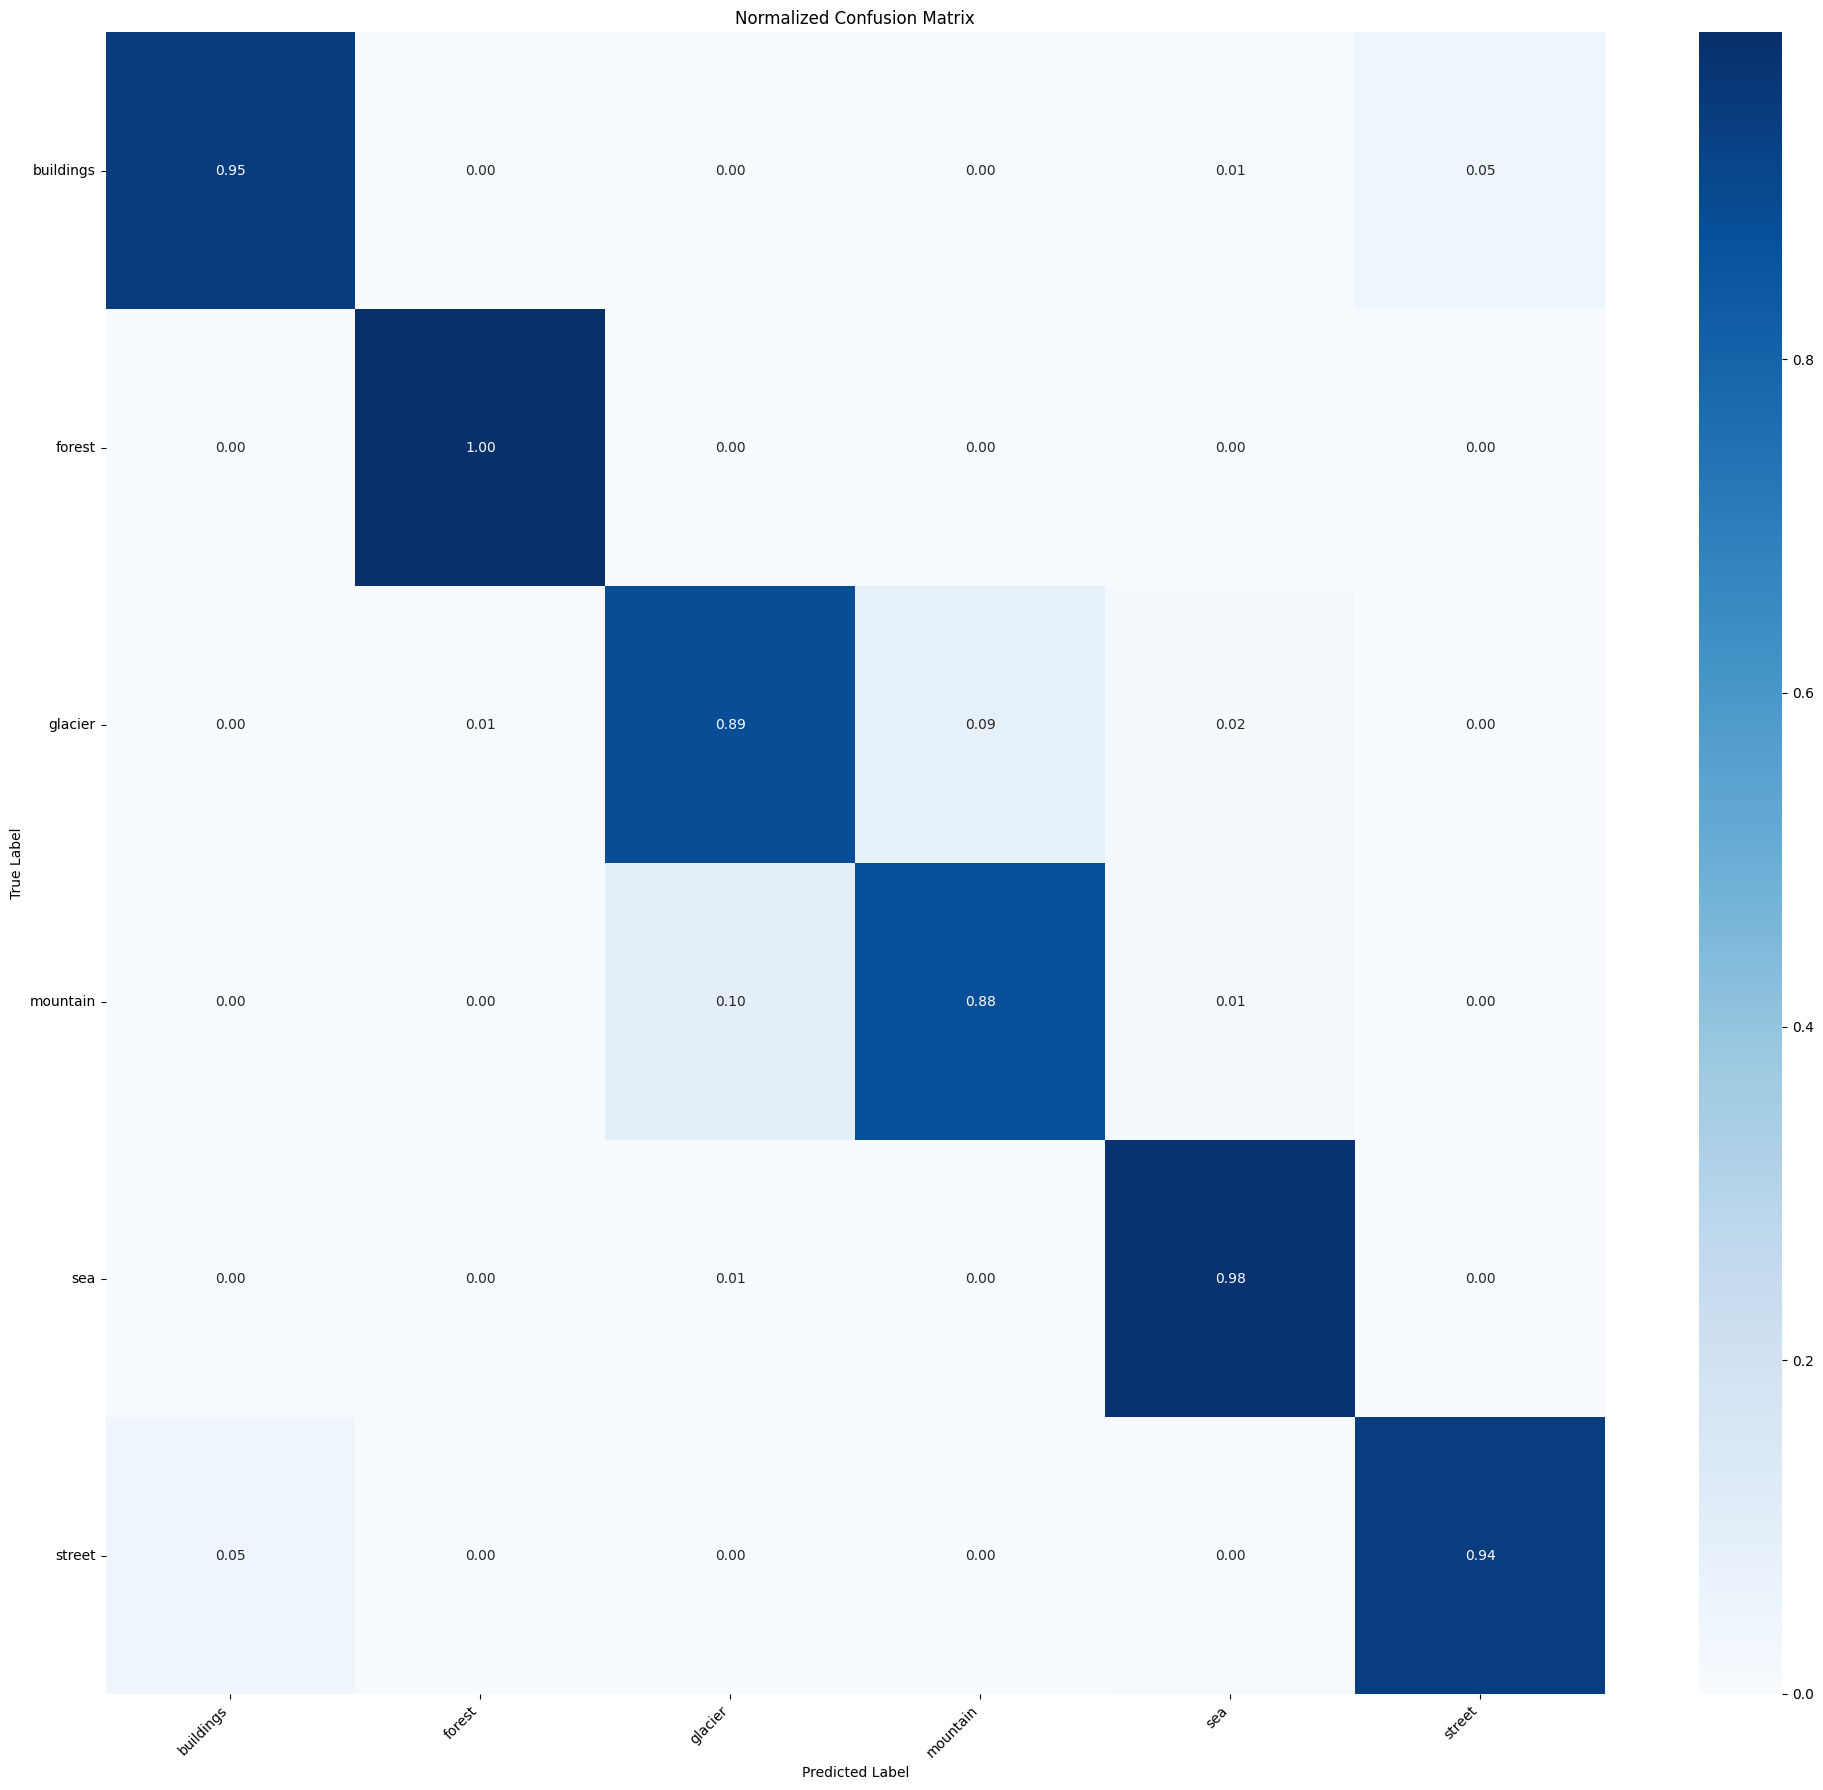

In [21]:
# 6. Evaluate on test set
test_results = evaluate_model(model, val_loader, class_names)
plot_confusion_matrix(
    test_results['confusion_matrix'],
    class_names,
    save_path='confusion_matrix.png'
)

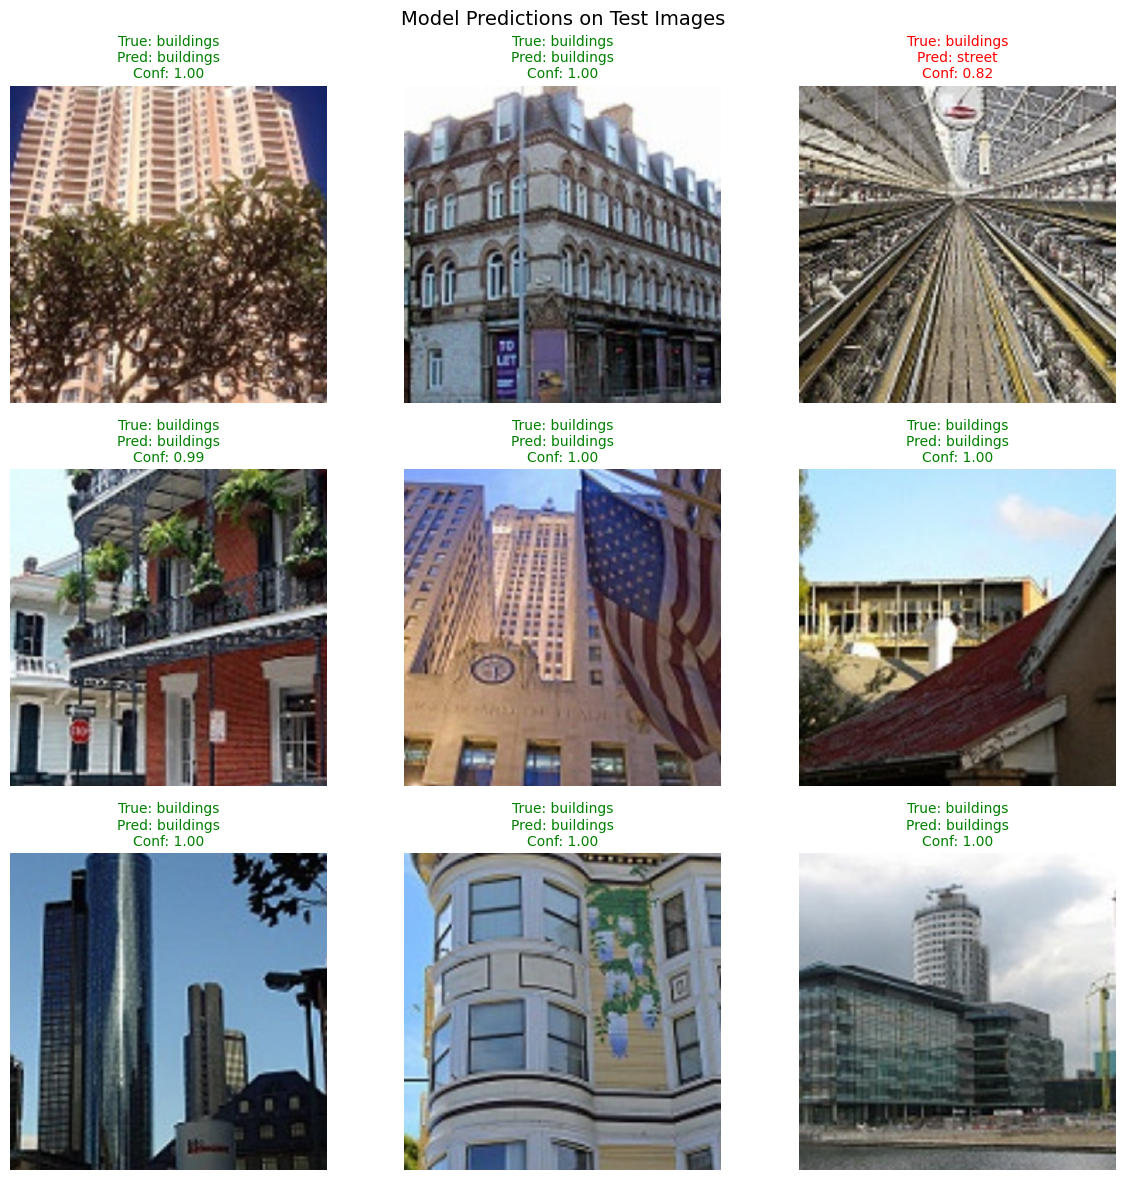

In [22]:
visualize_predictions(
    test_results['probabilities'], val_loader, class_names, 
    num_images=9, save_path="predictions_val.png"
)

In [18]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [
        test_results['accuracy'],
        test_results['precision'],
        test_results['recall'],
        test_results['f1']
    ]
})

metrics_df.to_csv('val_metrics.csv', index=False)
print("\nMetrics saved to 'val_metrics.csv'")

metrics_df.head(10)


Metrics saved to 'val_metrics.csv'


Metric     Value
0   Accuracy  0.955632
1  Precision  0.955900
2     Recall  0.955632
3   F1-Score  0.955670

# Own test predictions

In [ ]:
!wget "https://drive.google.com/uc?export=download&id=1iP6nnun_U7Ib-JHgUEWuUREqBICE0mAF" -O intel_test.zip

In [29]:
train_loader, val_loader, test_loader, class_names = create_dataloaders(
    config['data_dir'],
    batch_size=config['batch_size'],
    img_size=config['img_size']
)

Number of training samples: 14034
Number of validation samples: 3000
Number of test samples: 62
Number of classes: 6


Testing: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]



TEST SET RESULTS
Accuracy: 0.9839
Precision: 0.9853
Recall: 0.9839
F1-Score: 0.9839

Classification Report:
              precision    recall  f1-score   support

   buildings       1.00      1.00      1.00        10
      forest       1.00      0.92      0.96        12
     glacier       1.00      1.00      1.00        10
    mountain       0.91      1.00      0.95        10
         sea       1.00      1.00      1.00        10
      street       1.00      1.00      1.00        10

    accuracy                           0.98        62
   macro avg       0.98      0.99      0.98        62
weighted avg       0.99      0.98      0.98        62



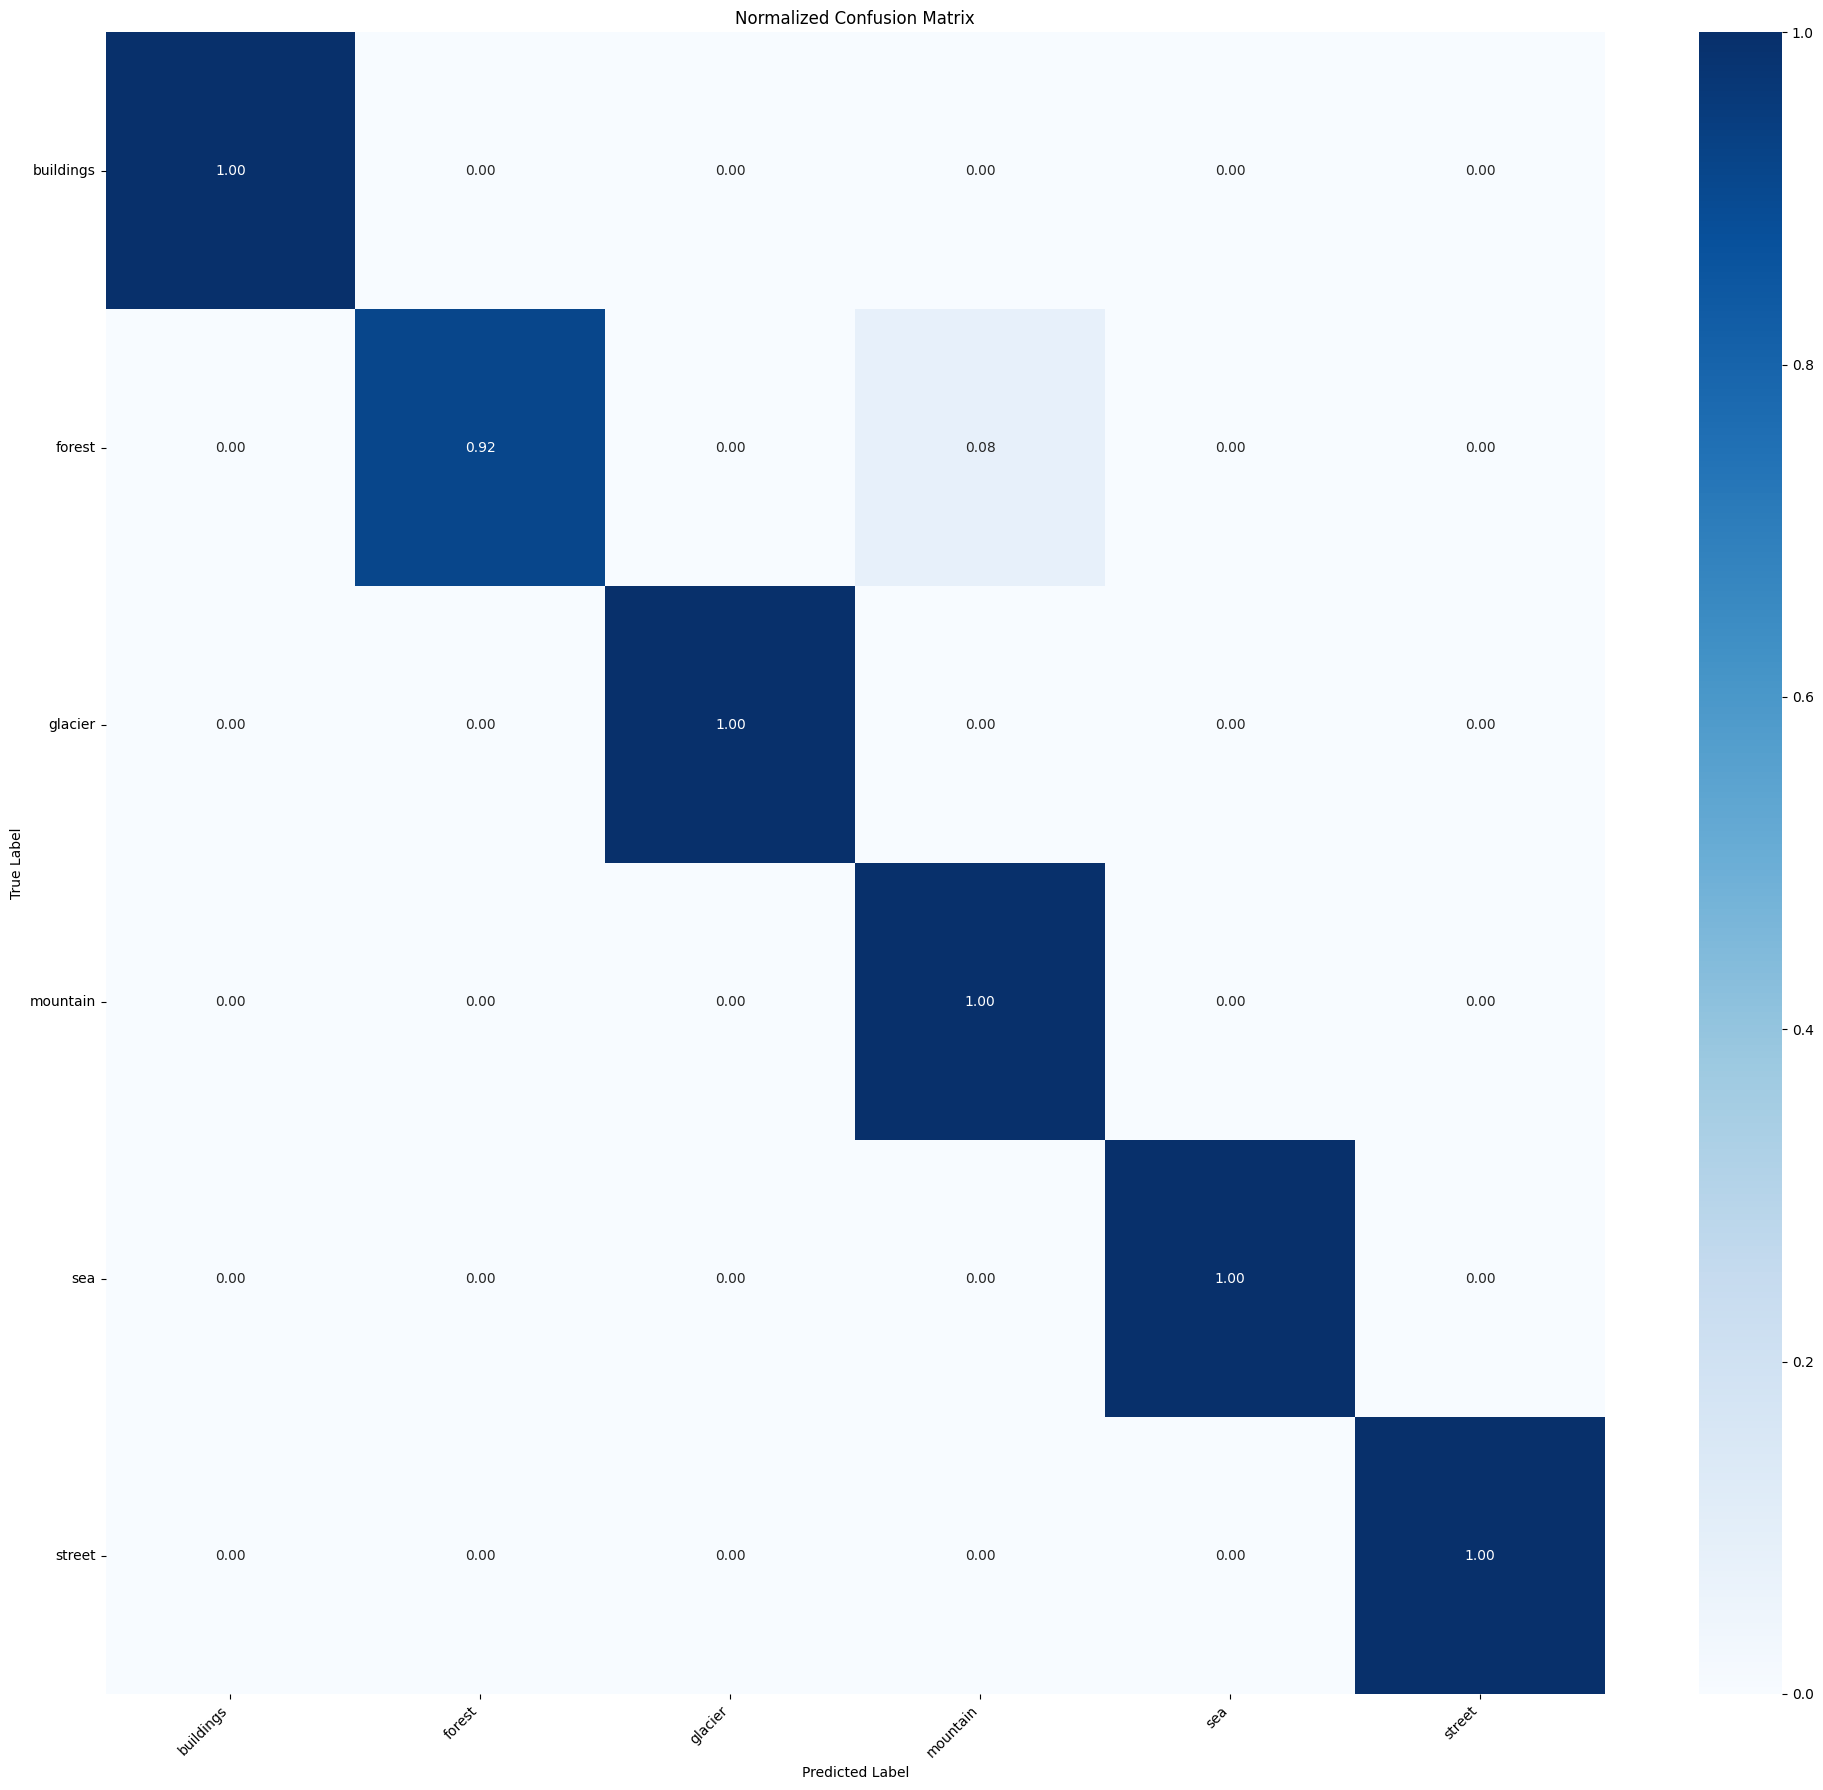

In [30]:
# 6. Evaluate on test set
test_results = evaluate_model(model, test_loader, class_names)
plot_confusion_matrix(
    test_results['confusion_matrix'],
    class_names,
    save_path='confusion_matrix_test.png'
)

Testing: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


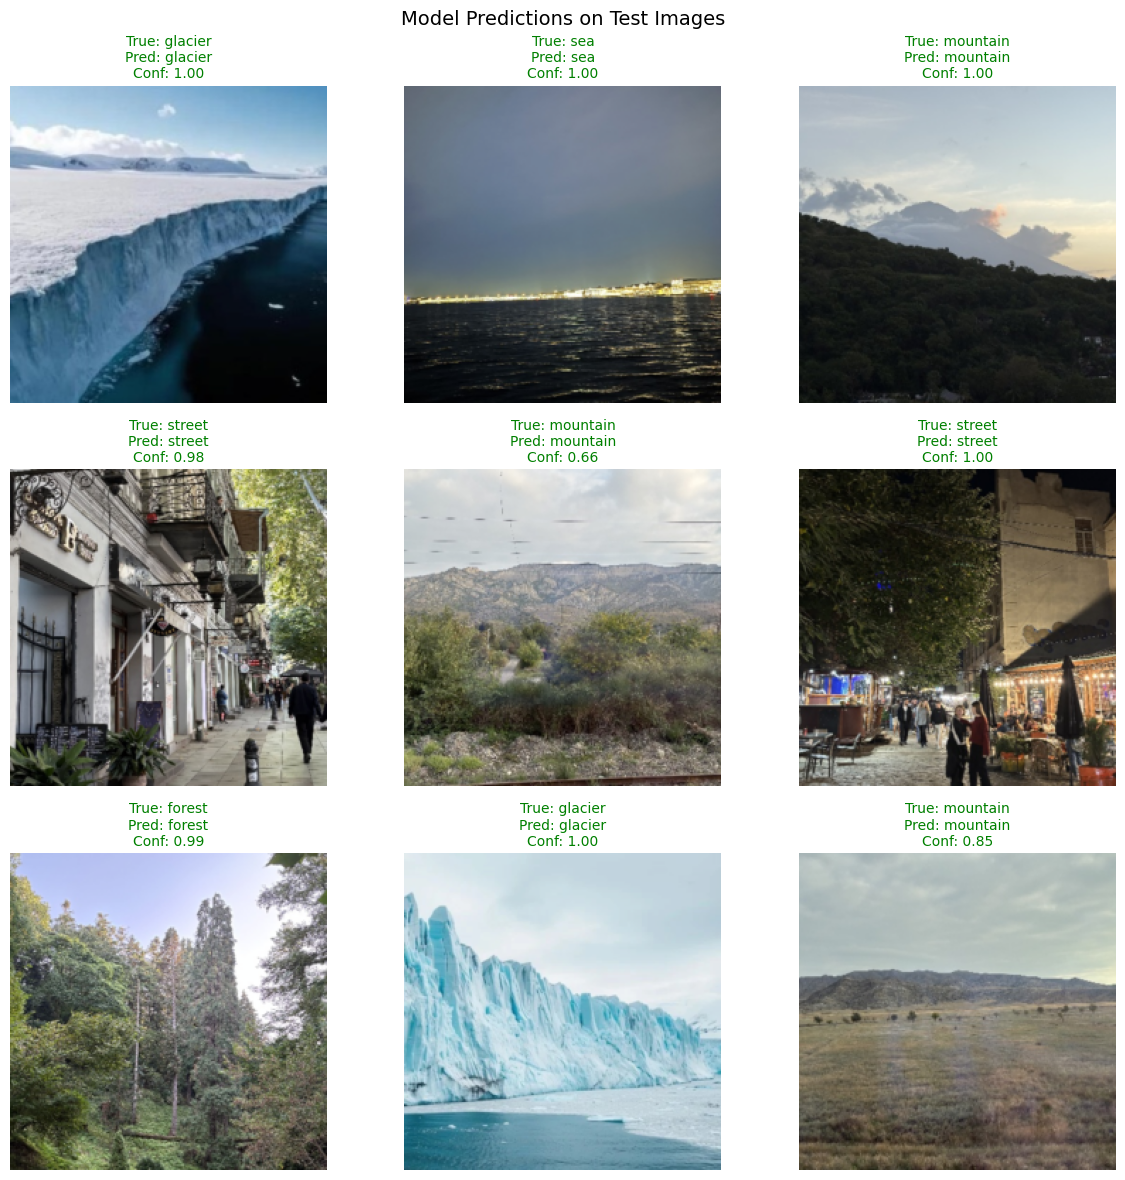

In [53]:
visualize_predictions(
    test_results['probabilities'], test_loader, class_names, 
    num_images=9, save_path="predictions_test.png"
)

In [61]:
test_results['predictions'] = np.array(test_results['predictions'])
test_results['labels'] = np.array(test_results['labels'])

print("Incorrect test:", np.sum(test_results['predictions'] != test_results['labels']))
incorrect_idx = np.argmax(test_results['predictions'] != test_results['labels'])
print("incorrect index:", incorrect_idx)

Incorrect test: 1
incorrect index: 14


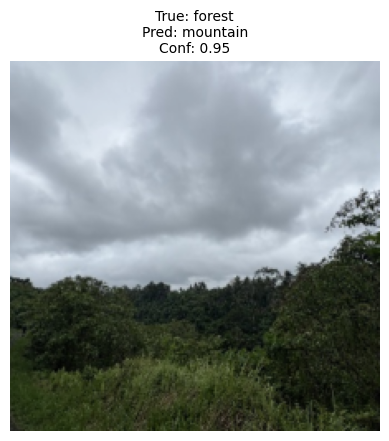

In [66]:
image, _ = next(iter(test_loader))
image = image[incorrect_idx].cpu().numpy()
mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
image = image * std + mean
image = np.clip(image, 0, 1)

plt.imshow(np.moveaxis(image, 0, -1))
true_label = class_names[test_results['labels'][incorrect_idx]]
pred_label = class_names[test_results['predictions'][incorrect_idx]]
confidence = test_results['probabilities'][incorrect_idx][test_results['predictions'][incorrect_idx]]

plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", fontsize=10)
plt.axis('off')
plt.show()

In [54]:
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Value': [
        test_results['accuracy'],
        test_results['precision'],
        test_results['recall'],
        test_results['f1']
    ]
})

metrics_df.to_csv('test_metrics.csv', index=False)
print("\nMetrics saved to 'test_metrics.csv'")

metrics_df.head(10)


Metrics saved to 'test_metrics.csv'


Metric     Value
0   Accuracy  0.983871
1  Precision  0.985337
2     Recall  0.983871
3   F1-Score  0.983904